In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean

spark = SparkSession.builder.appName("TelecomEDA").getOrCreate()

data = [
    (1, 8, 12),
    (2, None, 24),
    (3, 5, 36),
    (4, 7, 48)
]

telecom_df = spark.createDataFrame(data, ["CustomerID", "NPS", "Tenure"])

nps_mean = telecom_df.select(mean(col("NPS"))).collect()[0][0]

telecom_df = telecom_df.fillna({"NPS": nps_mean})

telecom_df.show()

+----------+---+------+
|CustomerID|NPS|Tenure|
+----------+---+------+
|         1|  8|    12|
|         2|  6|    24|
|         3|  5|    36|
|         4|  7|    48|
+----------+---+------+



In [3]:
from pyspark.sql.functions import when

data = [
    (1, 'Male'),
    (2, 'Female'),
    (3, 'Female'),
    (4, 'Male')
]

telecom_df = spark.createDataFrame(data, ["CustomerID", "Gender"])

telecom_df_encoded = telecom_df.withColumn("Gender_Male", when(telecom_df.Gender == "Male", 1).otherwise(0)) \
                               .withColumn("Gender_Female", when(telecom_df.Gender == "Female", 1).otherwise(0)) \
                               .drop("Gender")

telecom_df_encoded.show()

+----------+-----------+-------------+
|CustomerID|Gender_Male|Gender_Female|
+----------+-----------+-------------+
|         1|          1|            0|
|         2|          0|            1|
|         3|          0|            1|
|         4|          1|            0|
+----------+-----------+-------------+



In [4]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

data = [
    (50, 5), (60, 15),
    (55, 10), (70, 20)
]

telecom_df = spark.createDataFrame(data, ["MonthlyBill", "InternetUsage"])

assembler = VectorAssembler(inputCols=["MonthlyBill", "InternetUsage"], outputCol="features")
telecom_vector = assembler.transform(telecom_df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler.fit(telecom_vector).transform(telecom_vector).select("scaled_features").show(truncate=False)


+------------------------------------------+
|scaled_features                           |
+------------------------------------------+
|[-1.0246950765959597,-1.161895003862225]  |
|[0.14638501094227996,0.3872983346207417]  |
|[-0.43915503282683993,-0.3872983346207417]|
|[1.3174650984805196,1.161895003862225]    |
+------------------------------------------+



In [5]:
from pyspark.sql.functions import col

telecom_df = spark.createDataFrame([
    (12, 2),
    (24, 5),
    (36, 3),
    (48, 8)
], ["Tenure", "CallsToCare"])

telecom_df = telecom_df.withColumn("Tenure_CallsInteraction", col("Tenure") * col("CallsToCare"))

telecom_df.show()


+------+-----------+-----------------------+
|Tenure|CallsToCare|Tenure_CallsInteraction|
+------+-----------+-----------------------+
|    12|          2|                     24|
|    24|          5|                    120|
|    36|          3|                    108|
|    48|          8|                    384|
+------+-----------+-----------------------+



In [6]:
from pyspark.sql.functions import when

telecom_df = spark.createDataFrame([
    (1, 23),
    (2, 45),
    (3, 35),
    (4, 65)
], ["CustomerID", "Age"])

telecom_df = telecom_df.withColumn(
    "AgeGroup",
    when(col("Age") <= 30, "Young")
    .when((col("Age") > 30) & (col("Age") <= 50), "Middle-aged")
    .otherwise("Senior")
)

telecom_df.show()

+----------+---+-----------+
|CustomerID|Age|   AgeGroup|
+----------+---+-----------+
|         1| 23|      Young|
|         2| 45|Middle-aged|
|         3| 35|Middle-aged|
|         4| 65|     Senior|
+----------+---+-----------+



In [7]:
from pyspark.sql.functions import to_date, date_format

telecom_df = spark.createDataFrame([
    ('2024-01-01',),
    ('2024-02-15',),
    ('2024-03-20',),
    ('2024-04-25',)
], ["LastPaymentDate"])

telecom_df = telecom_df.withColumn("LastPaymentDate", to_date(col("LastPaymentDate")))
telecom_df = telecom_df.withColumn("PaymentDayOfWeek", date_format(col("LastPaymentDate"), "EEEE"))

telecom_df.show()

+---------------+----------------+
|LastPaymentDate|PaymentDayOfWeek|
+---------------+----------------+
|     2024-01-01|          Monday|
|     2024-02-15|        Thursday|
|     2024-03-20|       Wednesday|
|     2024-04-25|        Thursday|
+---------------+----------------+



In [8]:
from pyspark.sql.functions import sum

telecom_df = spark.createDataFrame([
    (1, '2024-01', 3),
    (1, '2024-02', 4),
    (2, '2024-01', 2),
    (2, '2024-02', 1)
], ["CustomerID", "Month", "DataDrops"])

telecom_aggregated = telecom_df.groupBy("CustomerID").agg(sum("DataDrops").alias("TotalDataDrops"))

telecom_aggregated.show()


+----------+--------------+
|CustomerID|TotalDataDrops|
+----------+--------------+
|         1|             7|
|         2|             3|
+----------+--------------+



In [9]:
from pyspark.sql.functions import col

telecom_df = spark.createDataFrame([
    (1, 50, 60),
    (2, 100, 120),
    (3, 150, 180),
    (4, 200, 240)
], ["CustomerID", "InternetUsage", "MonthlyBill"])

telecom_df = telecom_df.withColumn("UsageToBillRatio", col("InternetUsage") / col("MonthlyBill"))

telecom_df.show()


+----------+-------------+-----------+------------------+
|CustomerID|InternetUsage|MonthlyBill|  UsageToBillRatio|
+----------+-------------+-----------+------------------+
|         1|           50|         60|0.8333333333333334|
|         2|          100|        120|0.8333333333333334|
|         3|          150|        180|0.8333333333333334|
|         4|          200|        240|0.8333333333333334|
+----------+-------------+-----------+------------------+



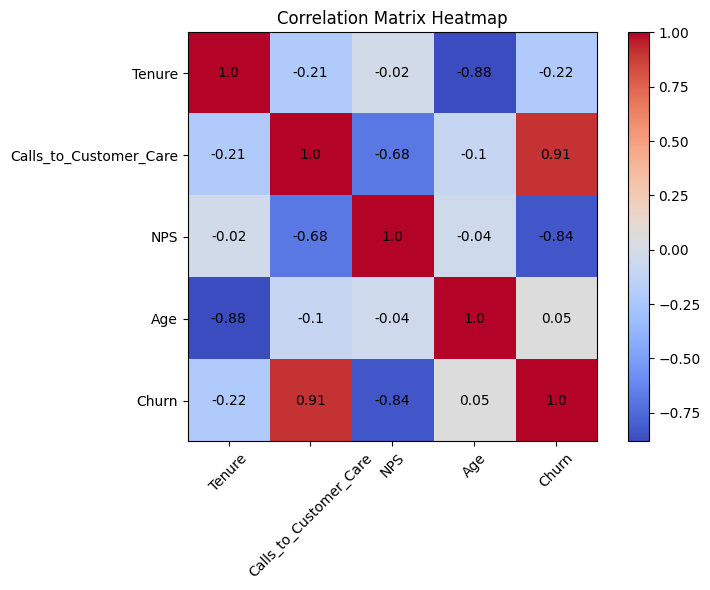

In [10]:
from pyspark.sql.functions import corr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = [
    (12, 2, 8, 45, 0),
    (24, 1, 9, 42, 0),
    (36, 4, 5, 33, 1),
    (6, 3, 4, 51, 1),
    (48, 1, 6, 37, 0)
]

columns = ["Tenure", "Calls_to_Customer_Care", "NPS", "Age", "Churn"]
telecom_df = spark.createDataFrame(data, columns)

correlations = {col1: [telecom_df.stat.corr(col1, col2) for col2 in columns] for col1 in columns}

correlation_matrix = pd.DataFrame(correlations, index=columns)

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, round(correlation_matrix.iloc[i, j], 2),
                 ha="center", va="center", color="black")

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()
